# IBM HR Analytics: Predicting employee attrition

* Title: IBM HR Analytics Employee Attrition & Performance
* Objective: Predict attrition of your valuable employees
* Kaggle link: https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset
* Inspired by: https://www.kaggle.com/arthurtok/employee-attrition-via-rf-gbm


The aim of this notebook is to show a step-by-step solution, explaining the basic concepts of data pre-processing, data analyzing, feature engineering and modeling.



---


If you are not familiar with Python and Data Science, but want to learn more, I suggest these courses:
1. __[Basic Python course for data science](https://www.datacamp.com/courses/intro-to-python-for-data-science)__
2. __[Machine Learning A-Z](https://www.udemy.com/machinelearning/learn/v4/overview)__
3. __[Machine Learning by Andrew Ng](https://www.coursera.org/learn/machine-learning)__

If you are not familiar with using __[Jupyter Notebook](http://jupyter.org/)__, the following links may be useful:
1. __[Jupyter notebook tutorial](https://www.datacamp.com/community/tutorials/tutorial-jupyter-notebook)__
2. __[Collection of Jupyter notebook plugins](https://github.com/ipython-contrib/jupyter_contrib_nbextensions)__ and __[Extension to control your Jupyter extensions](https://github.com/Jupyter-contrib/jupyter_nbextensions_configurator)__
4. __[Markdown for Jupyter notebooks cheatsheet](https://googleweblight.com/i?u=https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed&hl=pt-BR)__

# How  this notebook is organized

1. [Data pre-processing](#1.-Data-pre-processing)
2. [Data analysis](#2.-Data-analysis)
3. [Feature engineering](#3.-Feature-engineering)
4. [Feature selection](#4.-Feature-selection)
5. [Building various models](#5.-Building-various-models)
6. [Result comparison and final considerations](#6.-Result-comparison-and-final-considerations)

# The problem

We have a very rich HR dataset with information ranging from education level to relationship satisfaction. The main data of interest is "attrition", which indicates whether an employee had any problems in the workplace. Its prediction is very valuable, as it can be used to reduce the number of occurrences and allow the company to better understand the source of conflict.

As the value we're trying to predict (attrition) is categorical ("yes" or "no"), we're dealing with a __[classification](https://machinelearningmastery.com/classification-versus-regression-in-machine-learning/)__ problem. 

# 1. Data pre-processing

We start off by importing all libraries we're gonna use up until the [Feature Engineering](#Feature-engineering) section:
* numpy: array manipulation library
* pandas: csvs importing, dataframe manipulation
* seaborn: statistical data visualization
* matplotlib.pyplot: graph rendering
* tm1py: importing and writing back TM1/Planning Analytics Data

---

* LabelEncoder: converts categorical data into numerical
* train_test_split: helper method to split the dataset into training and test data
* accuracy_score: helper method to show the % of correct predictions made by a classifier/regressor
* cofusion_matrix: helper method to show to number of correct predictions for positive and negative cases

---

* RandomForestClassifier: random forest classifier implementation
* SVC: support vector machine classifier implementation, applicable to higher dimensions computations
* KNeighborsClassifier: nearest neighbors implementation
* GaussianNB: naive bayes implementation
* GridSearchCV: grid search implementation with k-fold cross-validation
* StandardScaler: normalizes the numeric variables of a dataframe, specially needed for SVM models

In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = 8
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

In [2]:
#!pip install tm1py
#bring TM1py library components to your Jupyter Notebook
from TM1py.Utils import Utils
from TM1py.Objects import Cube, Dimension, Hierarchy, Element, NativeView, Subset
from TM1py.Services import TM1Service
from datetime import timedelta, date
from TM1py.Services import TM1Service

Embed a Cognos Dashboard to get familar with the data in a highly interactive experience as opposed to complex and static python visualizations.   
This demonstrats very tights two-way integration between Notebooks and Cognos.

### Importing the data

The next step is to import the TM1/Planning Analytics HR Data using the pandas library, and take a look at quick peek at the data: 

In [3]:
#bring user name and password for Non-Interactive account from CSV file. 
#This information is in your Welcome Kit and this account will need access to TM1server that you will be using on this tenant
creds = CADataConnector.read_data(path=".public_folders/Shared Folder/CAPA/credentials.csv")
user=creds.iloc[0,0]
password=creds.iloc[0,1]

#also define your tenant
pTenant=creds.iloc[0,2]

#define TM1 server you will be using
pServer=creds.iloc[0,3]

#Tenant URL
base_url = 'https://' + pTenant + '.planning-analytics.ibmcloud.com/tm1/api/' + pServer


In [4]:
##Establish Planning Analytics Credentials

user = user
password = password
#SSLis always true for PA Cloud
ssl=True
#IBMCloud Name Space
namespace='LDAP'
#schoose your cube
cube_name = 'Employee Info'
#choose your view
view_name = 'EmployeeDetails'

#Establishing 
with TM1Service(base_url=base_url, 
                user=user,  
                password=password,
                namespace=namespace,
                ssl=ssl) as tm1:
    #bring your data set from TM1
    raw_data = tm1.cubes.cells.execute_view(cube_name=cube_name, view_name=view_name, private=False)
    # Build pandas DataFrame fram raw cellset data
    dataset = Utils.build_pandas_dataframe_from_cellset(raw_data, multiindex=False)

In [5]:
dataset.head()

,Employee,EmployeeDetails,Values
0,1,Age,41
1,1,Attrition,Yes
2,1,BusinessTravel,Travel_Rarely
3,1,DailyRate,1102
4,1,Department,Sales


In [102]:
dataset = dataset.set_index('Employee')
dataset.index = dataset.index.astype(int)
dataset = dataset.sort_index()

In [103]:
dataset=dataset.pivot_table(values='Values', index=dataset.index, columns='EmployeeDetails', aggfunc='first')

In [104]:
dataset = dataset.fillna(0)
dataset.head()

EmployeeDetails,Age,Attrition,BusinessTravel,DailyRate,...,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
Employee,,,,,,,,,
1,41,Yes,Travel_Rarely,1102,...,6,4,0,5
2,49,No,Travel_Frequently,279,...,10,7,1,7
4,37,Yes,Travel_Rarely,1373,...,0,0,0,0
5,33,No,Travel_Frequently,1392,...,8,7,3,0
7,27,No,Travel_Rarely,591,...,2,2,2,2


In [105]:
datasetOrig = dataset.copy()
datasetOrig.describe

<bound method NDFrame.describe of EmployeeDetails  Age Attrition     BusinessTravel  DailyRate  \
Employee                                                       
1                 41       Yes      Travel_Rarely       1102   
2                 49        No  Travel_Frequently        279   
4                 37       Yes      Travel_Rarely       1373   
5                 33        No  Travel_Frequently       1392   
7                 27        No      Travel_Rarely        591   
8                 32        No  Travel_Frequently       1005   
10                59        No      Travel_Rarely       1324   
11                30        No      Travel_Rarely       1358   
12                38        No  Travel_Frequently        216   
13                36        No      Travel_Rarely       1299   
14                35        No      Travel_Rarely        809   
15                29        No      Travel_Rarely        153   
16                31        No      Travel_Rarely        670   
18    

In [106]:
# number of entries
print("Number of entries: " + str(len(dataset.index)))

Number of entries: 1470


In [107]:
len(datasetOrig)

1470

### Checking for empty values

With that done, we need to clean up the dataset, dealing with missing values if necessary. The following command shows which columns have null values:

In [108]:
dataset.isnull().any()

EmployeeDetails
Age                         False
Attrition                   False
BusinessTravel              False
DailyRate                   False
Department                  False
DistanceFromHome            False
Education                   False
EducationField              False
EmployeeCount               False
EmployeeNumber              False
EnvironmentSatisfaction     False
Gender                      False
HourlyRate                  False
JobInvolvement              False
JobLevel                    False
JobRole                     False
JobSatisfaction             False
MaritalStatus               False
MonthlyIncome               False
MonthlyRate                 False
NumCompaniesWorked          False
Over18                      False
OverTime                    False
PercentSalaryHike           False
PerformanceRating           False
RelationshipSatisfaction    False
StandardHours               False
StockOptionLevel            False
TotalWorkingYears           Fals

In this case, __there's no empty values__, which is great! However, if there were, we could evaluate what step to take next by counting how many empty values we have:

<div class="alert alert-block alert-warning">dataset.isnull().sum()</div>

Which can also be done column by column:

> dataset[col].isnull().sum() 

There are a few ways to deal with empty values, the most popular being removing rows with empty values: 

> dataset.dropna()

There are __[many approaches](https://machinelearningmastery.com/handle-missing-data-python/)__  to handle missing data, such as filling the gaps with the __[mean value](https://www.vocabulary.com/articles/chooseyourwords/mean-median-average/)__  of the column:

> from sklearn.preprocessing import Imputer

> imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)

> imputer = imputer.fit(X[:, colStart:colEnd])

> X[:, colStart:colEnd] = imputer.transform(X[:, colStart:colEnd])

It all depends on your data; in some cases using the median can lead to better results (specially when your data has __[outliers](https://towardsdatascience.com/a-brief-overview-of-outlier-detection-techniques-1e0b2c19e561)__):

> [1, 2, 3, 4, 50]

The median of the set above is 3, while the mean (or average) is 31.

# 2. Data analysis

Before creating any Machine Learning models, one must first take a look at the data with the following questions in mind:
* Are there strong relations between the features? Features that are too similar are redundant.
* Do I need all the features? Could the model be simplified somehow?
* Could some features be combined, or transformed somehow, to better represent the problem at hand? (e.g. with time variables, sometimes all you need is the hour or day, not the full date).

Many times these questions can only be answered after running a model, and testing out some hypothesis. However, looking at some graphs may help this process.

Given infinite resources and time, *we could* look into all combinations. However, since there are many columns on this dataset, we're gonna choose only a few relations to analyze:
* EducationField, MonthlyIncome
* PerformanceRating, JobSatisfaction
* NumCompaniesWorked, PerformanceRating
* EducationField, JobSatisfaction
* YearsWithCurrManager, JobSatisfaction
* MonthlyRate, JobSatisfaction
* DistanceFromHome, WorkLifeBalance
* PerformanceRating, Overtime
* WorkLifeBalance, Overtime
* RelationshipSatisfaction, Overtime
* MaritalStatus, YearsInCurrentRole
* MartialStatus, YearsSinceLastPromotion

We start by defining a set of subplots (in this case, 5 by 3), and then plot the graphs.

It's important to use the right graph for the right data. __[Seaborn](https://seaborn.pydata.org/)__ library is specially fitting for data analysis because you can run it with categorical data. __[There's quite a few options to choose from](https://seaborn.pydata.org/tutorial/categorical.html)__, you may need to do some experimenting in order to find the best plot.

Text(0.5, 1.0, 'Monthly income against Educational Field')

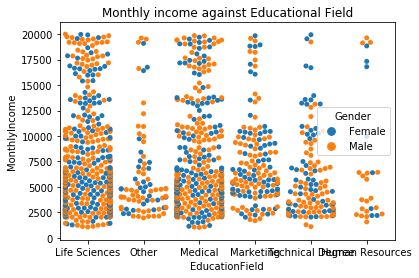

In [109]:
sns.swarmplot(x="EducationField", y="MonthlyIncome", data=dataset, hue="Gender").set_title("Monthly income against Educational Field")


Text(0.5, 1.0, 'Job satisfaction against Performance Rating')

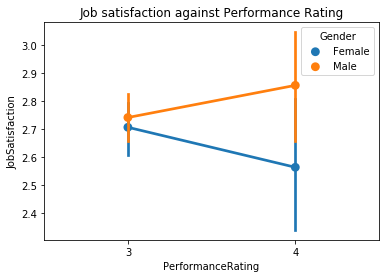

In [110]:
sns.pointplot(x="PerformanceRating", y="JobSatisfaction", data=dataset, hue="Gender").set_title("Job satisfaction against Performance Rating")

Text(0.5, 1.0, 'Number of companies worked against Performance rating')

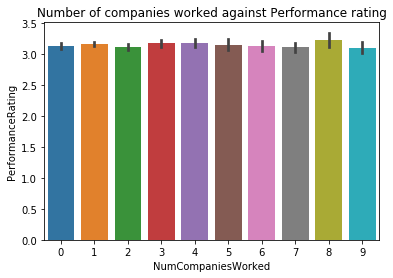

In [111]:
sns.barplot(x="NumCompaniesWorked", y="PerformanceRating", data=dataset).set_title("Number of companies worked against Performance rating")

Text(0.5, 1.0, 'Educational Field against Job Satisfaction')

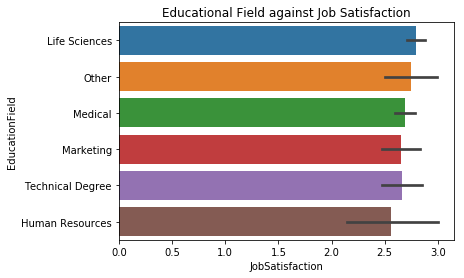

In [112]:
sns.barplot(x="JobSatisfaction", y="EducationField", data=dataset).set_title("Educational Field against Job Satisfaction")

Text(0.5, 1.0, 'Years with current Manager against Job Satisfaction')

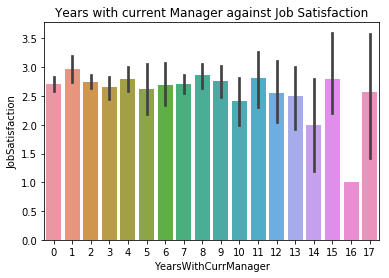

In [113]:
sns.barplot(x="YearsWithCurrManager", y="JobSatisfaction", data=dataset).set_title("Years with current Manager against Job Satisfaction")

Text(0.5, 1.0, 'Distance from home against Work life balance')

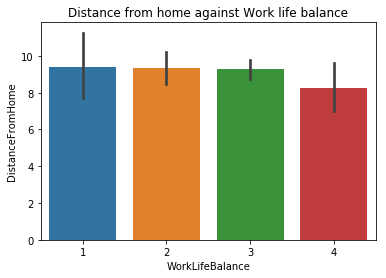

In [114]:
sns.barplot(x="WorkLifeBalance", y="DistanceFromHome", data=dataset).set_title("Distance from home against Work life balance")

Text(0.5, 1.0, 'Age against Years since last promotion')

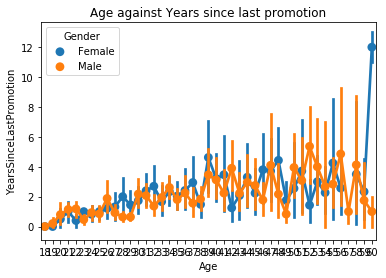

In [115]:
sns.pointplot(x="Age", y="YearsSinceLastPromotion", hue="Gender", data=dataset).set_title("Age against Years since last promotion")

Text(0.5, 1.0, 'Performance Rating against Gender')

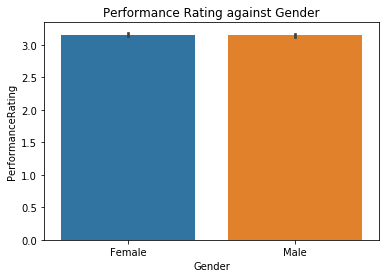

In [116]:
sns.barplot(x="Gender", y="PerformanceRating", data=dataset).set_title("Performance Rating against Gender")

Text(0.5, 1.0, 'Job satisfaction against Gender')

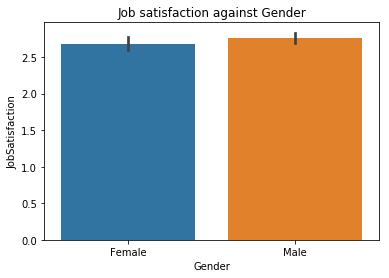

In [117]:
sns.barplot(x="Gender", y="JobSatisfaction", data=dataset).set_title("Job satisfaction against Gender")

Text(0.5, 1.0, 'Attrition distribution')

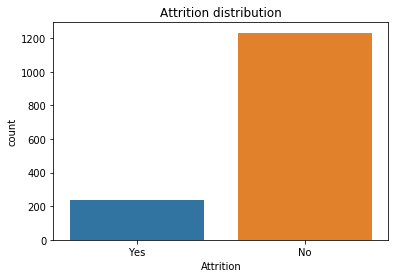

In [118]:
sns.countplot(x="Attrition", data=dataset).set_title("Attrition distribution")


We can make a few inferences from the data shown above:
* MaritalStatus seems to indicate the same thing as Age in terms of promotions (and possibly other data), so maybe we can remove one of these.
* Male RelationshipSatisfication and WorkLifeBalance are both highly affected by Overtime, maybe one of these could be dropped.
* EducationalField and MonthlyIncome seems to be redundant, since there's a big correlation between them.
* Overtime seems to affect different variables in different manners, also showing great variance between males and females.
* Year 16 of YearsWithCurrentManager could be removed from the dataset, as it seems to be an outlier.
* Only 16% of the employees had any kind of attrition in the workplace, which means that the distribution for our output variable is quite unbalanced.

Fun facts:
* Men who do overtime are happier on their relationships, while Women are not affected much by it.
* Women have better perform reviews than men when overtime was done.

# 3. Feature engineering

Feature Engineering is the art/science of representing data in the best way possible and involves a combination of intuition, field knowledge, experience and common sense. If you want to dig deeper into this topic, __[this guide](http://adataanalyst.com/machine-learning/comprehensive-guide-feature-engineering/)__ provides a great overview with practical examples.

For this particular dataset, we have two main things to do before running a model:
1. Decide what features we should keep.
2. Transform categorical data into numerical.

---

On the previous section, data analysis has shown that a few columns are redundant and could be removed, mainly: **MaritalStatus** and **EducationField**. However, since we don't know yet which is more important, we'll keep them for now, and re-evaluate after we build our first model. However, **EmployeeNumber** and **EmployeeCount** are evidently irrelevant features, so we can remove them. We could probably find many other columns to drop, but we can do that later by analyzing the results from our first ML model.

In [119]:
if 'EmployeeNumber' in dataset:
    del dataset['EmployeeNumber']
    
if 'EmployeeCount' in dataset:
    del dataset['EmployeeCount']

### Splitting the data

Before transforming the categorical data, we can separate the input features "X" from the output "y", which is needed for the model to understand what are the features (or inputs), and what value you are trying to predict (and doing this separation before the encoding is practical). The split is done through the **iloc** command, which is part of the pandas library:

<div class="alert alert-block alert-warning">dataset.iloc[rowStart:rowEnd, colStart:colEnd]</div>

When the dataset is well organized, this is normally done as follows:

<div class="alert alert-block alert-warning">X = dataset.iloc[:, 0:N-1].values</div>

<div class="alert alert-block alert-warning">y = dataset.iloc[:, N].values</div>

However, since the output variable is not located at the end, we're going to extract the features __[dataframe](https://pandas.pydata.org/pandas-docs/stable/dsintro.html#dataframe)__ by dropping the output variable:

In [120]:
features = dataset[dataset.columns.difference(['Attrition'])]
output = dataset.iloc[:, 1]

### Encoding

As mentioned before, the categorical data must be converted into numbers for the Machine Learning model to work. This can be done through:
* **LabelEncoder**: transform your textual column in a numeric continuous one (ranging from 1-N).
> In MaritalStatus, value "Single", "Married" and "Divorced" could be represented as 0, 1 and 2, respectively


* **OneHotEncoder**: transform your textual column in many binary ones (0-1). 
> In MaritalStatus, two separate columns could represent "Single" as 1 and 0, "Married" as 0 and 1 and "Divorced as 0 and 0.

As rule of thumb, **OneHotEncoder** _is a much better approach to use_, mainly because it prevents models from making wrong assumptions. **LabelEncoder** can turn [dog,cat,dog,mouse,cat] into [1,2,1,3,2], which could lead a model to infer that the average of dog and mouse is cat. However, some algorithms (like *decision trees* and *random forests*) can work with these categorical variables just fine, and LabelEncoder can be used to store values using less disk space.

Even though our first model will be a *random forest* implementation, we're gonna  **hot encode** every categorical column, as it will allow us to build different models and remind us of the importance of doing proper encoding in most cases.

There are many ways of building your hot encoded feature map, the most popular ones being from __[sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)__ and __[pandas](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)__. In this notebook, I've choosen the pandas approach.

First, we split the categorical columns from the numerical ones:

In [121]:
categorical = []
for col, value in features.iteritems():
    if value.dtype == 'object':
        categorical.append(col)

# Store the numerical columns in a list numerical
numerical = features.columns.difference(categorical)

print(categorical)

['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']


The code above gave us two arrays, splitting the categorical from the numerical data.

With that information, we can now encode the categorical data into a binary representation. There are several ways of doing that, the most popular being __[OneHotEncode](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)__ from sklearn and __[get_dummies](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)__ from pandas. Due to its simplicity, we are going to use the latter, with the **drop_first** parameter set to *true* (which help us avoiding the __[dummy variable trap](http://www.algosome.com/articles/dummy-variable-trap-regression.html)__):

In [122]:
# get the categorical dataframe, and one hot encode it
features_categorical = features[categorical]
features_categorical = pd.get_dummies(features_categorical, drop_first=True)
features_categorical.head()

,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,...,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
Employee,,,,,,,,,
1,0,1,0,1,...,0,0,1,1
2,1,0,1,0,...,0,1,0,0
4,0,1,1,0,...,0,0,1,1
5,1,0,1,0,...,0,1,0,1
7,0,1,1,0,...,0,1,0,0


<a id="feature_map"></a>
### Getting the feature map

We can now build our final feature map by getting all the numerical features concatenated with the newly generated columns:

In [123]:
# get the numerical dataframe
features_numerical = features[numerical]

# concatenate the features
features = pd.concat([features_numerical, features_categorical], axis=1)

features.head()

,Age,DailyRate,DistanceFromHome,Education,...,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
Employee,,,,,,,,,
1,41,1102,1,2,...,0,0,1,1
2,49,279,8,1,...,0,1,0,0
4,37,1373,2,2,...,0,0,1,1
5,33,1392,3,4,...,0,1,0,1
7,27,591,2,1,...,0,1,0,0


### Getting the output variable

For the output variable (our output), we only need a simple label encoder

In [124]:
labelencoder = LabelEncoder()
output = labelencoder.fit_transform(output)

print(output)

[1 0 1 ... 0 0 0]


### Splitting the dataset

The last data pre-processing step is to split the __[training and test set](https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7)__. There's no hard rule on how to split the data, but it usually ranges between 70-90% for the training set (unless you are working with a *HUGE* dataset, in which case you may go with very different distributions, such as 30-70% (using more data on the test set).

For this problem, a standard distribution of 70/30% was chosen:

In [125]:
features_train, features_test, attrition_train, attrition_test = train_test_split(features, output, test_size = 0.3, random_state = 0)

In [126]:
len(attrition_test)

441

In [127]:
len(attrition_train)

1029

# 4. Feature selection

Feature selection is a very important step in machine learning model building. There are several tools that can help one pick the best features, among them we have the random forest model which provides as feedback the relative importance of each feature.

### Random Forest

__[Decision trees](https://www.lucidchart.com/pages/decision-tree)__ have been present on the AI field for a long time, being used on both __[expert systems](https://blog.leanix.net/en/artificial-intelligence-expert-systems)__ and __[machine learning models](https://towardsdatascience.com/decision-trees-in-machine-learning-641b9c4e8052)__. On Machine Learning, a decision tree may be applied to both __[classification and regression](https://helloacm.com/a-short-introduction-classification-and-regression-trees/)__ problems. It has a pretty simple structure, where a sequence of questions with weights are answered in order to get a prediction:

<img src="https://helloacm.com/wp-content/uploads/2016/03/decision-tree.jpg" style="width: 50%" alt="Decision tree missing :(" title="Decision tree structure" />

These models are pretty good if you have lots and lots of data (more specifically, it performs well for problems with many features/attributes), but they tend to  __[overfit](https://machinelearningmastery.com/overfitting-and-underfitting-with-machine-learning-algorithms/)__ badly. The example below shows how a tree classifier can lead to very __[greedly separated data](https://jakevdp.github.io/PythonDataScienceHandbook/05.08-random-forests.html)__:
<img src="https://i.imgur.com/LbwfSH7.png" alt="Decision tree result visualization" title="Decision tree" />

This kind of behavior made them fall in disuse for ML models (although they are still popular for expert systems). The introduction of __[random forests](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)__, which is an __[ensemble](https://www.toptal.com/machine-learning/ensemble-methods-machine-learning)__ of decision trees, revitalized this model, as it's able to generalize better and is generally less prone to be affected by outliers. In short, it builds an *n* number of trees with different sub-sets of the data and features, which then are averaged at the end to provide the final prediction.

<img src="https://cdn-images-1.medium.com/max/592/1*i0o8mjFfCn-uD79-F1Cqkw.png" alt="Random forest missing" title="Random forest" />


When working on a classification problem, it's almost always a great idea to start with __[sklearn RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)__; not only it's a pretty good classifier for many problems, but it also allows you evaluate what was the impact of each feature on the prediction. This is precious information, as one can build better models by removing undesirable features. There are other ways of figuring out which features are important to our model such as __[sklearn feature selection](http://scikit-learn.org/stable/modules/feature_selection.html)__, but we won't experiment with it on this notebook.

### Building the first model

Since the main target of this first step is to take a closer look at the features, we won't fiddle much with the __[hyper-parameters](https://machinelearningmastery.com/difference-between-a-parameter-and-a-hyperparameter/)__ of the model besides specifying the use of 800 trees (n_estimators):

In [128]:
random_forest = RandomForestClassifier(n_estimators = 800, criterion = 'entropy', random_state = 0)
random_forest.fit(features_train, attrition_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

### Prediction

The random forest classifier was successfully built, which means we can now we can use it to predict employee attrition from datasets unknown to it, and see how well it performs. If things go sour and you get an underwhelming result, it could mean a few things:
1. The model does not generalize well, and we need to either do more feature engineering, change the hyper-parameters or the model altogether.
2. We don't have enough data.
3. This problem can't be modeled with the known features.

We can only hope it's not (2) or (3).

---

We stat by running the predict method on the test set and compare the results with the attrition test set:

In [129]:
# Get the prediction array, 
attrition_pred = random_forest.predict(features_test)

# Get the accuracy %
print("Accuracy: " + str(accuracy_score(attrition_test, attrition_pred) * 100) + "%") 

Accuracy: 86.39455782312925%


In [130]:
####
# Get the prediction array against the full set of data
RF_attrition_pred_full = random_forest.predict(features)
len(RF_attrition_pred_full)
datasetOutput = datasetOrig.copy()
# merge the prediction with the original dataset
datasetOutput['RF_Prediction'] = RF_attrition_pred_full
len(datasetOutput)
datasetOutput.tail()

EmployeeDetails,Age,Attrition,BusinessTravel,DailyRate,...,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,RF_Prediction
Employee,,,,,,,,,
2061,36,No,Travel_Frequently,884,...,2,0,3,0
2062,39,No,Travel_Rarely,613,...,7,1,7,0
2064,27,No,Travel_Rarely,155,...,2,0,3,0
2065,49,No,Travel_Frequently,1023,...,6,0,8,0
2068,34,No,Travel_Rarely,628,...,3,1,2,0


In [131]:
# trim out everything except what we need to push back to Cognos

datasetOutput2 = datasetOutput[['EmployeeNumber', 'Attrition', 'RF_Prediction']]
datasetOutput2.head()

# Write data from Pandas Dataframe back to Cognos 
CADataConnector.write_data(datasetOutput2 , path=".my_folders/HR_Attrition_Prediction", mode="w")

In [132]:
datasetOutput.tail(50)

EmployeeDetails,Age,Attrition,BusinessTravel,DailyRate,...,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,RF_Prediction
Employee,,,,,,,,,
1999,41,No,Travel_Rarely,642,...,3,1,0,0
2000,47,No,Non-Travel,1162,...,8,5,12,0
2003,35,No,Travel_Rarely,1490,...,2,2,2,0
2007,22,No,Travel_Rarely,581,...,2,1,2,0
2008,35,No,Travel_Rarely,1395,...,7,0,8,0
2009,33,No,Travel_Rarely,501,...,7,8,1,0
2010,32,No,Travel_Rarely,267,...,2,4,1,0
2012,40,No,Travel_Rarely,543,...,0,0,0,0
2013,32,No,Travel_Rarely,234,...,2,2,2,0


In [133]:
len(RF_attrition_pred_full)

1470

### Analysis

We got a training accuracy of approximately 86%, which is pretty good! However, results may be deceiving: in order to properly evaluate how well our model is performing, we need to know how many attrition cases it predicted correctly. This is specially important in this case, as our output variable is very unbalanced (only 14% of the cases are attrition).

The best way to do that is using a __[confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)__. A confusion matrix is as big as your output variable's possible outcomes; in this case, it's a 2x2 matrix to represent prediction results for "attrition" and "no attrition" cases. The correct predictions are always shown on the diagonal of the table (from top left to bottom right):

<img src="https://i.stack.imgur.com/KxrxP.png" alt="Confusion Matrix img missing :(" title="Confusion Matrix" />

To build it, all you need is the sklearn confusion_matrix function, the test-set output value "attrition_test" which we obtained when [splitting the dataset](#Splitting-the-dataset) and the predicted output "attrition_pred", which we obtained when running the predict method on our classifier:

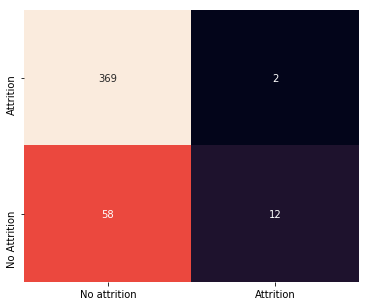

In [134]:
# Making the Confusion Matrix
rf_cm = confusion_matrix(attrition_test, attrition_pred)

# building a graph to show the confusion matrix results
rf_cm_plot = pd.DataFrame(rf_cm, index = [i for i in {"Attrition", "No Attrition"}],
                  columns = [i for i in {"No attrition", "Attrition"}])
plt.figure(figsize = (6,5))
sns.heatmap(rf_cm_plot, annot=True, vmin=5, vmax=90.5, cbar=False, fmt='g')

The results shown above show us that:

1. We **correctly** predicted 369 entries as "No Attrition" and 11 entries as "Attrition"
2. We **incorrectly** predicted __58 entries as "No Attrition"__ and 2 as "Attrition"

Although our model had an accuracy of 86%, these results are not good. The main goal of our model is to __catch scenarios where employee attrition may occur__, in which we had an *abysmal* performance of approximately **17%** with the test set.

We can improve the situation a bit by applying known techniques such as cross-validation and re-sampling, which we will do on the [Testing New Models](#Testing-New-Models) section.

### Evaluating the weight of the features 

As we got a pretty underwhelming result, it's time to go back to the drawing board and see what can be improved. The first thing we need to look at is our features, as there are many benefits in reducing the amount of inputs:
* Models are easier to understand and show better performance when we have less features
* Some features may be redundant and represent the same thing as others (e.g. maybe age and marital status?), thus only being noise 
* Some features are not relevant to the model and may impact negatively on the prediction

Luckily, the model we just built has a built-in functionality that allow us to analyze the weight of each feature as shown below:

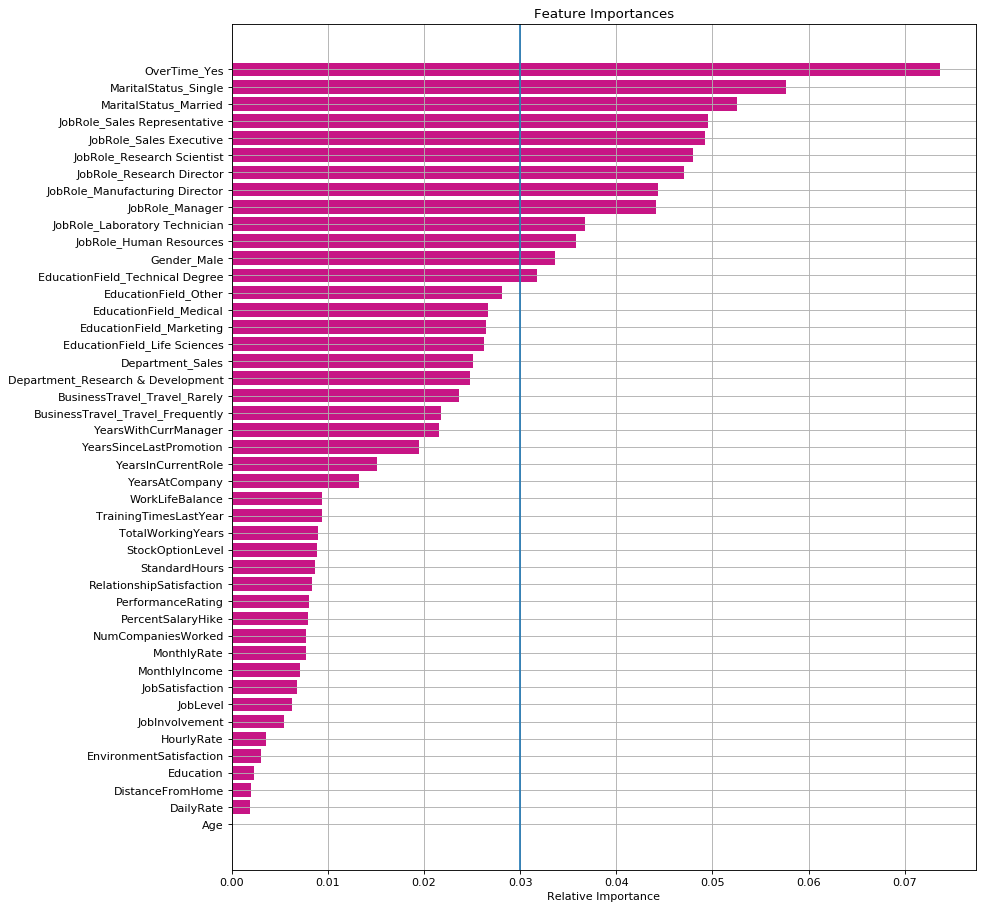

In [135]:
def plot_feature_importances(importances, features):
    # get the importance rating of each feature and sort it
    indices = np.argsort(importances)

    # make a plot with the feature importance
    plt.figure(figsize=(12,14), dpi= 80, facecolor='w', edgecolor='k')
    plt.grid()
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], height=0.8, color='mediumvioletred', align='center')
    plt.axvline(x=0.03)
    plt.yticks(range(len(indices)), list(features))
    plt.xlabel('Relative Importance')
    plt.show()

plot_feature_importances(random_forest.feature_importances_, features)

The graph above is pretty simple to understand: the higher the relative importance is, the better. However, when looking at a feature importance map we need to keep a few things in mind. No model is able to properly evaluate the relative importance of features if they have high correlation, which our dataset seems to have a lot of. Also, categorical features which have many possible values also tend to be over-evaluated too.

With that in mind, where do we draw the line? There's no rule of thumb: we can make our own assumptions and run a few iterations to see what suit us best:

1. First and foremost, **overtime** seems to be the most important feature, and any good model we build will have to include it.
2. **Martial status** is also very important, and it's important to keep both **maried** and **single** features, as they also serve to indicate a divorced status, which may be an important factor.
3. We get to a lot of **job roles** features with high impact, which are likely boosted in importance due to its variety. This is made more obvious due to the fact that **ALL** job roles are very similarly ranked in relative importance. We need to reduce the number of features and keep only what is crucial information; the easiest way to achieve that with the current data  is to remove the department information and keep the job roles. 
4. We should keep the gender; not only it had a good score but we also spotted a few interesting behaviors at the [data analysis section](#Data-Analysis).
5. We should keep some of the top numerical features for now. Even though they didn't show high impact, it may be due to the boosted importance of categorical fields. We'll experiment with the most impactful ones: **YearsWithCurrManager**, **YearsSinceLastPromotion** and **YearsAtCompany**.

Everything else will be cut for now, following the vertical blue line that was drawn in the plot above.


### Building the new feature dataframe

In order to build our new feature map, we need to manipulate the features dataframe we built [previously](#feature_map) and *filter* only the desirable inputs:

In [136]:
new_features = (features.filter(['OverTime_Yes', 'MaritalStatus_Single', 'MaritalStatus_Married', 'JobRole_Sales Representative', 
                                 'JobRole_Sales Executive', 'JobRole_Research Scientist', 'JobRole_Research Director', 'JobRole_Manufacturing Director', 
                                 'JobRole_Manager', 'JobRole_Laboratory Technician', 'JobRole_Human Resources', 'Gender_Male', 'YearsWithCurrManager', 
                                 'YearsSinceLastPromotion', 'YearsAtCompany']))
new_features.head()

,OverTime_Yes,MaritalStatus_Single,MaritalStatus_Married,JobRole_Sales Representative,...,Gender_Male,YearsWithCurrManager,YearsSinceLastPromotion,YearsAtCompany
Employee,,,,,,,,,
1,1,1,0,0,...,0,5,0,6
2,0,0,1,0,...,1,7,1,10
4,1,1,0,0,...,1,0,0,0
5,1,0,1,0,...,0,0,3,8
7,0,0,1,0,...,1,2,2,2


The next step is to build a new train-step data split in order to train new models:

In [137]:
features_train_new, features_test_new, attrition_train_new, attrition_test_new = train_test_split(new_features, output, test_size = 0.3, random_state = 0)

And that's it, we have our new training/test data! We can now re-train our model and see what we get from it.

### Retraining the Random Forest classifier

With the the new training/test data available, we can re-visit the random forest we built and see if we get better results. We still won't focus much on the hyper-parameters, we just want to have a rough idea if we're going into the right direction.

In [138]:
# Build the new classifier
random_forest_new = RandomForestClassifier(n_estimators = 800, criterion = 'entropy', random_state = 0)
random_forest_new.fit(features_train_new, attrition_train_new)

# Get the prediction array, 
attrition_pred_new = random_forest_new.predict(features_test_new)

# Get the accuracy %
print("Accuracy: " + str(accuracy_score(attrition_test_new, attrition_pred_new) * 100) + "%") 

Accuracy: 81.40589569160997%


From a first glance, our model actually got worst! Before we had a precision of 86%, and now only 81%. However, we should take a look at the confusion matrix before jumping into conclusions:

[Text(0.5, 1.0, 'Random Forest CM (Selected features)')]

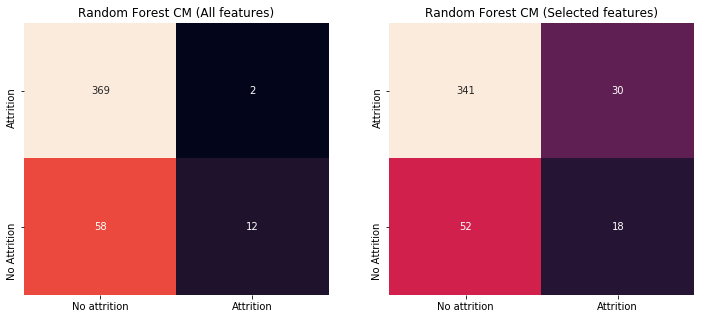

<Figure size 432x360 with 0 Axes>

In [139]:
# Define a set of graphs, 1 by 2, to show the previous and the new confusion matrix side by side
f, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=False, sharey=False)
plt.figure(figsize = (6,5))

# building a graph to show the old confusion matrix results
sns.heatmap(rf_cm_plot, annot=True, vmin=5, vmax=90.5, cbar=False, fmt='g', ax=axes[0])
axes[0].set( title = 'Random Forest CM (All features)')

# Making the new Confusion Matrix
rf_cm_new = confusion_matrix(attrition_test_new, attrition_pred_new)
rf_cm_new_plot = pd.DataFrame(rf_cm_new, index = [i for i in {"Attrition", "No Attrition"}],
                  columns = [i for i in {"No attrition", "Attrition"}])

# building a graph to show the new confusion matrix results
sns.heatmap(rf_cm_new_plot, annot=True, vmin=10, vmax=90.5, cbar=False, fmt='g', ax=axes[1])
axes[1].set( title = 'Random Forest CM (Selected features)')

Note that we had a worst score in the "no attrition" identification, which means our model would flag employees as trouble makers in potential when they are not. This is, however, not as severe as failing to identify someone as a potential workplace attrition source. In that regard, we have effectively improved our model from **17%** to **25.7%** accuracy, but that's still far from ideal.

We can now take a new look at the feature relevant from our new feature sub-set:

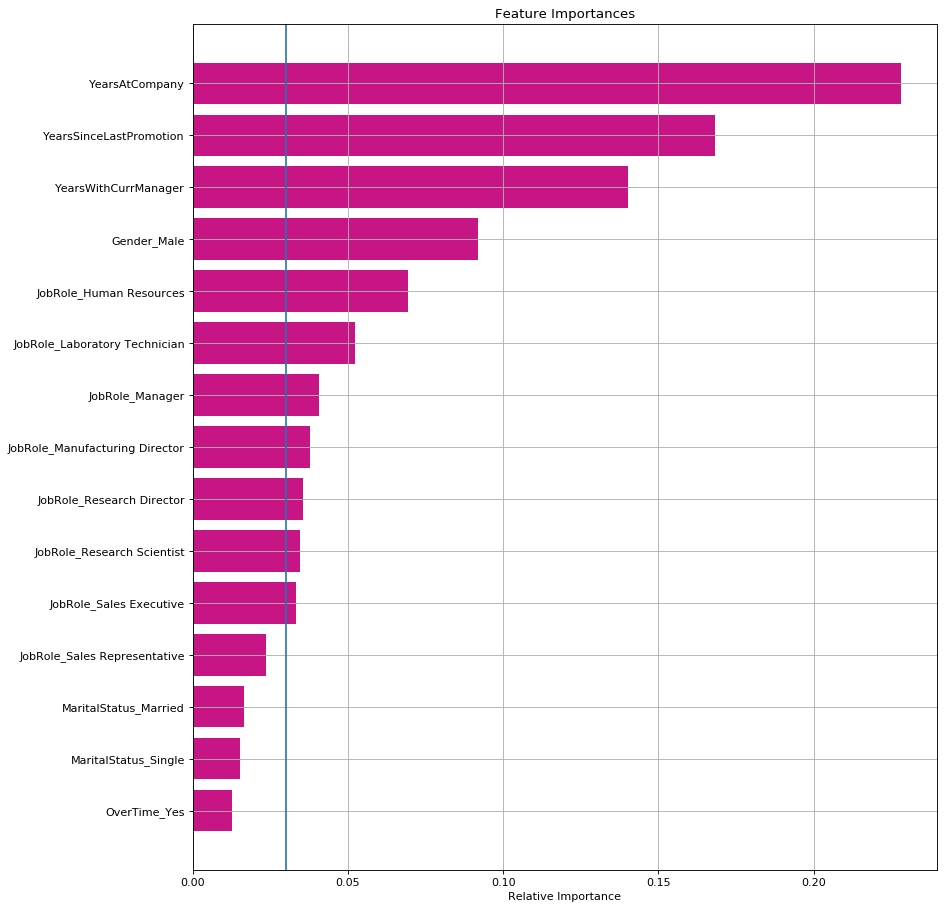

In [140]:
plot_feature_importances(random_forest_new.feature_importances_, new_features)

Removing many features has shown that overtime was, perhaps, wrongly evaluated (or that we removed some key features that overtime required to show its impact). The plot above shows that employees that are stuck in the same position for a long time (company time, time since last promotion and time with current manager) are more likely to cause trouble, which makes sense; most people are not happy with the same routine for long periods of time.

The changes we made also show that, perhaps, the job role or the department aren't very important features, but this will be made clear when we build the new models. More work could be done here, and more hypothesis could be drawn; however, it's time to experiment with different models and fine-tune them, and see what we can get.

### Feature Scaling

A few models we are going to build do not work well with __[un-normalized data](https://machinelearningmastery.com/rescaling-data-for-machine-learning-in-python-with-scikit-learn/)__, so we're also going to generate scalled verions of the feature map:

In [141]:
sc = StandardScaler()
features_train_scaled = sc.fit_transform(features_train)
features_test_scaled = sc.transform(features_test)
features_train_new_scaled = sc.fit_transform(features_train_new)
features_test_new_scaled = sc.transform(features_test_new)

# 5. Building various models

On this section we'll be experimenting with many well-known classification models:
* K-Nearest Neighbors (K-NN)
* Kernel SVM
* Naive Bayes
* Random forest


We'll start by building the models with their default hyper-parameters, then we'll fine-tune each with __[grid search](https://www.packtpub.com/mapt/book/big_data_and_business_intelligence/9781783555130/6/ch06lvl1sec40/fine-tuning-machine-learning-models-via-grid-search)__ and compare the results.  

### Grid Search

Grid search is a brute-force search algorithm used to find the best hyper-parameter combination for a given problem. The __[sklearn module](http://scikit-learn.org/stable/modules/grid_search.html)__ has a nice implementation of it with a built in __[K-fold cross-validation](https://www.cs.cmu.edu/~schneide/tut5/node42.html)__, which builds smaller models with "K" portions of the data set, better evaluating how well a model generalizes. In this study, we'll use K=5.

However, we still need to pick what hyper-parameters we will play with and within what range, as it would be prohibitively expensive to attempt all possible combinations (and that's not how the algorithm works). From it, we expect to find what is the best combination of hyper-parameters for each model and, at the end, hopefully we'll end up with a model that has good performance for this problem.

As seen before, we have quite the unbalanced dataset, which means any model we build will achieve high accuracy while getting almost all "attrition" cases wrong. The reason for this is that a model may look at the data and decide that the best thing to do is to always predict “no attrition” and achieve high accuracy. __[There are several ways to avoid this](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/)__, one of which is to apply smarter cross-validation scoring.

The chosen metric for this study is the **F1 score**, a weighted average of precision and recall. Recall is a metric of a model completeness, that is, the number of positive predictions divided by the number of positive class values in the test data. 

Since we'll be building quite a few grid search models with confusion matrix plots, it's better if we define some helper methods:

In [142]:
def plot_two_confusion_matrix(cm_1, title_1, cm_2, title_2):
    # Define a set of graphs, 1 by 2, to show the previous and the new confusion matrix side by side
    f, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=False, sharey=False)
    plt.figure(figsize = (6,5))

    # Builds the first CM plot
    cm_1_plot = pd.DataFrame(cm_1, index = [i for i in {"Attrition", "No Attrition"}],
                      columns = [i for i in {"No attrition", "Attrition"}])
    sns.heatmap(cm_1_plot, annot=True, vmin=5, vmax=90.5, cbar=False, fmt='g', ax=axes[0])
    axes[0].set(title = title_1)

    # Builds the second CM plot
    cm_2_plot = pd.DataFrame(cm_2, index = [i for i in {"Attrition", "No Attrition"}],
                      columns = [i for i in {"No attrition", "Attrition"}])
    sns.heatmap(cm_2_plot, annot=True, vmin=10, vmax=90.5, cbar=False, fmt='g', ax=axes[1])
    axes[1].set( title = title_2)

# We could have built a generic method to plot N number of confusion matrix, but we won't need it for this notebook
def plot_four_confusion_matrix(cm_1, title_1, cm_2, title_2, cm_3, title_3, cm_4, title_4):
    # Define a set of graphs, 2 by 2, to show the previous and the new confusion matrix side by side
    f, axes = plt.subplots(2, 2, figsize=(12, 12), sharex=False, sharey=False)
    plt.figure(figsize = (6,5))

    # Builds the first CM plot
    cm_1_plot = pd.DataFrame(cm_1, index = [i for i in {"Attrition", "No Attrition"}],
                      columns = [i for i in {"No attrition", "Attrition"}])
    sns.heatmap(cm_1_plot, annot=True, vmin=5, vmax=90.5, cbar=False, fmt='g', ax=axes[0,0])
    axes[0,0].set(title = title_1)

    # Builds the second CM plot
    cm_2_plot = pd.DataFrame(cm_2, index = [i for i in {"Attrition", "No Attrition"}],
                      columns = [i for i in {"No attrition", "Attrition"}])
    sns.heatmap(cm_2_plot, annot=True, vmin=10, vmax=90.5, cbar=False, fmt='g', ax=axes[0,1])
    axes[0,1].set( title = title_2)

    # Builds the third CM plot
    cm_3_plot = pd.DataFrame(cm_3, index = [i for i in {"Attrition", "No Attrition"}],
                      columns = [i for i in {"No attrition", "Attrition"}])
    sns.heatmap(cm_3_plot, annot=True, vmin=10, vmax=90.5, cbar=False, fmt='g', ax=axes[1,0])
    axes[1,0].set( title = title_3)

    # Builds the fourth CM plot
    cm_4_plot = pd.DataFrame(cm_4, index = [i for i in {"Attrition", "No Attrition"}],
                      columns = [i for i in {"No attrition", "Attrition"}])
    sns.heatmap(cm_4_plot, annot=True, vmin=10, vmax=90.5, cbar=False, fmt='g', ax=axes[1,1])
    axes[1,1].set( title = title_4)
    
# Fit the classifier, get the prediction array and print the accuracy
def fit_and_pred_classifier(classifier, X_train, X_test, y_train, y_test):
    # Fit the classifier to the training data
    classifier.fit(X_train, y_train)

    # Get the prediction array
    y_pred = classifier.predict(X_test)
    
    # Get the accuracy %
    print("Accuracy with selected features: " + str(accuracy_score(y_test, y_pred) * 100) + "%") 
    
    return y_pred

# Run grid search, get the prediction array and print the accuracy and best combination
def fit_and_pred_grid_classifier(classifier, param_grid, X_train, X_test, y_train, y_test, scoring = "f1", folds = 5):
    # Apply grid search with F1 Score to help balance the results (avoid bias on "no attrition")
    grid_search = GridSearchCV(estimator = classifier, param_grid = param_grid, cv = folds, scoring = scoring, n_jobs = -1, verbose = 0)
    grid_search.fit(X_train, y_train)
    best_accuracy = grid_search.best_score_
    best_parameters = grid_search.best_params_

    # Get the prediction array
    grid_search_pred = grid_search.predict(X_test)

    # Print the accuracy and best parameter combination
    print(scoring + " score: " + str(best_accuracy * 100) + "%")
    print("Accuracy: " + str(accuracy_score(y_test, grid_search_pred) * 100) + "%") 
    print("Best parameter combination: " + str(best_parameters)) 
    
    return grid_search_pred, grid_search_pred

### K-Nearest Neighbors (K-NN)

The K-Nearest Neighbors algorithm is __[non-parametric](http://www.statisticshowto.com/parametric-and-non-parametric-data/)__, that is, it doesn't make any assumptions on the underlying data-distribution. It operates by grouping elements together based on the K nearest neighbors, where K (e.g. K=5) and method used to calculate the distance (e.g. Euclidean) are configurable. Similarly to SVM, KNN does not work well with un-normalized data, so we'll use scaled features. The first model we're going to build will all the features, with K=5:

In [143]:
knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)

# Get the prediction array
knn_pred = fit_and_pred_classifier(knn, features_train_scaled, features_test_scaled, attrition_train, attrition_test)

Accuracy with selected features: 85.26077097505669%


Let's now try it out with the selected group of features:

In [144]:
knn_new = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)

# Get the prediction array
knn_pred_new = fit_and_pred_classifier(knn_new, features_train_new_scaled, features_test_new_scaled, attrition_train_new, attrition_test_new)

Accuracy with selected features: 84.58049886621315%


We apparently got better results with the selected group of features, but we can't be too sure just yet without analyzing the confusion matrix. Now that we built two simple K-NN models, it's time to apply grid search. These are the hyper-parameters we will cover:
    
* n_neighbors = number neighbors 
* weights = weight function used on prediction
* algorithm = algorithm used to compute the nearest neighbor
* metrics = the distance metric to use for the tree. 
* p = Power parameter for the Minkowski metric. p=1: manhattan_distance, p=2: euclidean_distance

The following range of values were chosen:

In [145]:
param_grid = {
    'n_neighbors': [1,2,4,5],
    'weights': ['distance', 'uniform'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'metric': ['minkowski','euclidean','manhattan'], 
    'p': [1, 2]
}

With the grid parameters built, we can now perform grid search on our KNN models, starting with all the features:

In [146]:
# Run grid search, print the results and get the prediction array and model
knn_grid_search_pred, knn_grid = (fit_and_pred_grid_classifier(knn, param_grid, 
                                                               features_train_scaled, features_test_scaled, 
                                                               attrition_train, attrition_test))

f1 score: 28.97508846288358%
Accuracy: 82.76643990929705%
Best parameter combination: {'algorithm': 'ball_tree', 'metric': 'minkowski', 'n_neighbors': 1, 'p': 1, 'weights': 'distance'}


Now let's run grid search on a knn model built with the selected group of features:

In [147]:
# Run grid search, print the results and get the prediction array and model
knn_grid_search_pred_new, knn_grid_new = (fit_and_pred_grid_classifier(knn_new, param_grid, 
                                                                       features_train_new_scaled, features_test_new_scaled, 
                                                                       attrition_train_new, attrition_test_new))

f1 score: 41.10188682558402%
Accuracy: 83.21995464852607%
Best parameter combination: {'algorithm': 'brute', 'metric': 'minkowski', 'n_neighbors': 5, 'p': 2, 'weights': 'distance'}


We got slightly better results with the selected group of features, but our *F1 score* is still a bit low (41%). Let us now build the confusion matrix and analyze the results:

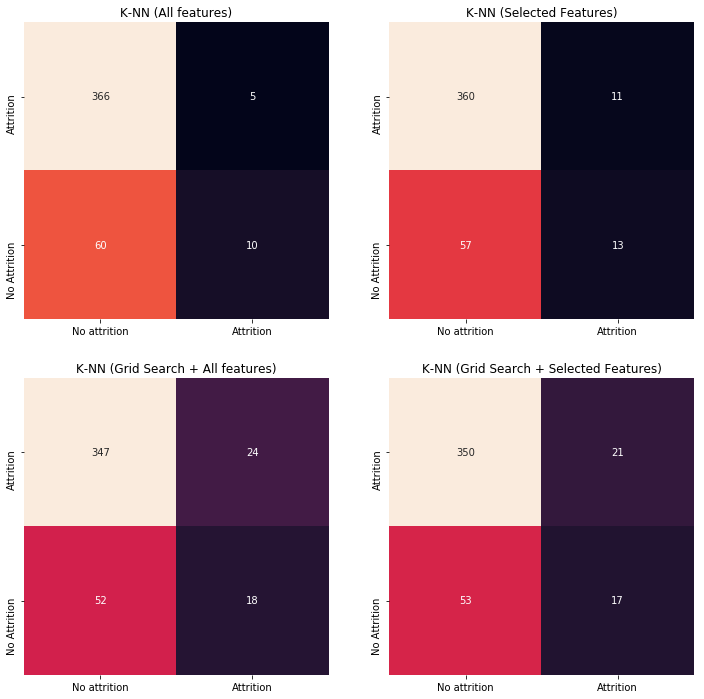

<Figure size 432x360 with 0 Axes>

In [148]:
# Build the Confusion Matrix with all features
knn_cm = confusion_matrix(attrition_test, knn_pred)

# Build the Confusion Matrix with the selected features
knn_cm_new = confusion_matrix(attrition_test_new, knn_pred_new)

# Build the Confusion Matrix with all features and grid search
knn_grid_cm = confusion_matrix(attrition_test, knn_grid_search_pred)

# Build the Confusion Matrix with the selected features and grid search
knn_grid_cm_new = confusion_matrix(attrition_test_new, knn_grid_search_pred_new)

# Plot the four Coufusion Matrix
plot_four_confusion_matrix(knn_cm, 'K-NN (All features)', 
                           knn_cm_new, 'K-NN (Selected Features)',
                           knn_grid_cm, 'K-NN (Grid Search + All features)', 
                           knn_grid_cm_new, 'K-NN (Grid Search + Selected Features)')

K-NN performed very similarly to random forest, not showing much promise in terms of attrition prediction, while showing overall good accuracy. K-NN doesn't seem like a very promising model for this problem.

### Kernel SVM

Kernel SVM allows us to map the data to a higher dimension, allowing non-linear problems to be linearly separable (SVM). It's very popular due to its flexibility and performance.

As mentioned before, SVM does not work well with un-normalized data, so we're going to use scaled features. We start by building a very simple Kernel SVM model. For starters, I've chosen a Gaussian (rbf) kernel, which is a pretty good initial setup:

In [149]:
# Build the model and fit it to the training data
svc = SVC(kernel = 'rbf', random_state = 0)

# Get the prediction array
svc_pred = fit_and_pred_classifier(svc, features_train_scaled, features_test_scaled, attrition_train, attrition_test)

Accuracy with selected features: 87.3015873015873%


We got an accuracy of 87.3%, which is the highest we've seen so far! Let's do the same now for the selected group of features:

In [150]:
# Build the model and fit it to the training data
svc_new = SVC(kernel = 'rbf', random_state = 0)

# Get the prediction array
svc_pred_new = fit_and_pred_classifier(svc_new, features_train_new_scaled, features_test_new_scaled, attrition_train_new, attrition_test_new)

Accuracy with selected features: 83.90022675736961%


We got an accuracy of almost 84%, which at first glance seems worst than the Kernel SVM model with all the features, but we can't be too sure until looking at the Confusion Matrix. Now, let's see what we can achieve with a grid search, we are going to cover the following hyper-parameters:
* kernel = Specifies the kernel type to be used in the algorithm. It must be one of ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ or a callable
* gamma = Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’
* C = Penalty parameter C of the error term.

The following range of values were chosen:

In [151]:
param_grid = [
    {
        'C': [1, 2, 4, 5], 
        'kernel': ['linear']
    }, 
    {
        'C': [10, 11, 12, 13, 14, 15], 
        'kernel': ['rbf', 'sigmoid'], 
        'gamma': [0.1, 0.2, 0.3, 0.4, 0.5]
    },
]

 With the grid parameters built, we can now try it out on our Kernel SVM classifier with all the features:

In [152]:
# Run grid search, print the results and get the prediction array and model
svc_grid_search_pred, svc_grid = (fit_and_pred_grid_classifier(svc, param_grid, features_train_scaled, 
                                                               features_test_scaled, attrition_train, 
                                                               attrition_test, scoring = "recall"))

recall score: 39.5435230369204%
Accuracy: 88.88888888888889%
Best parameter combination: {'C': 1, 'kernel': 'linear'}


Interestingly enough the best result out of 920 combinations was a simple line (while also being the best overall performance so far from all models we've built). KISS, I guess. We should now run grid search with the Kernel SVM model built with the selected group of features:

In [153]:
# Run grid search, print the results and get the prediction array and model
svc_grid_search_pred_new, svc_grid_new = (fit_and_pred_grid_classifier(svc, param_grid, 
                                                                       features_train_new_scaled, features_test_new_scaled, 
                                                                       attrition_train_new, attrition_test_new, scoring = "recall"))

recall score: 35.29351134393151%
Accuracy: 82.76643990929705%
Best parameter combination: {'C': 13, 'gamma': 0.2, 'kernel': 'rbf'}


With an accuracy rating of 88.88% and 82.7%, Kernel SVM is showing good promise. Let us now compare the confusion matrix of all SVC models:

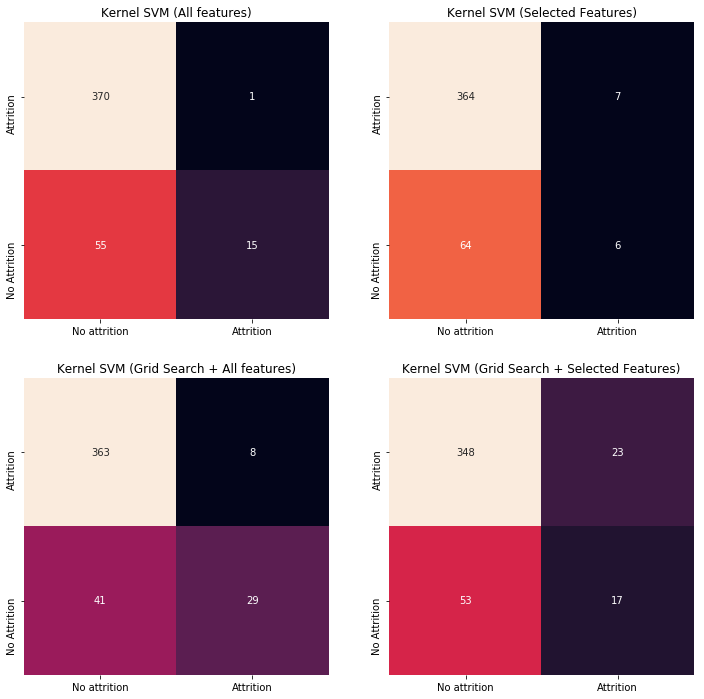

<Figure size 432x360 with 0 Axes>

In [154]:
# Build the Confusion Matrix with all features
svc_cm = confusion_matrix(attrition_test, svc_pred)

# Build the Confusion Matrix with the selected features
svc_cm_new = confusion_matrix(attrition_test_new, svc_pred_new)

# Build the Confusion Matrix with all features and grid search
svc_grid_cm = confusion_matrix(attrition_test, svc_grid_search_pred)

# Build the Confusion Matrix with the selected features and grid search
svc_grid_cm_new = confusion_matrix(attrition_test_new, svc_grid_search_pred_new)

# Plot the four Coufusion Matrix
plot_four_confusion_matrix(svc_cm, 'Kernel SVM (All features)', 
                           svc_cm_new, 'Kernel SVM (Selected Features)',
                           svc_grid_cm, 'Kernel SVM (Grid Search + All features)', 
                           svc_grid_cm_new, 'Kernel SVM (Grid Search + Selected Features)')

Linear SVM with all the features got the best overall accuracy so far. However, it's still an underwhelming "attrition" prediction. That being said, it may still be useful to us when building our own ensemble.

### Naive Bayes

Naive Bayes is a family of algorithms that all share a common principle: every feature is independent from each other. For example, a fruit may be considered an apple if it is red, round, and about 3″ in diameter. A Naive Bayes classifier considers each of these features to contribute independently to the prediction, regardless of any correlations between features. This is, of course, almost never true, which means that the applications of this model are very situational. However, it often gives good results, showing better results than other models that do not have their hyper-parameters fine-tuned.

It's a pretty simple model, and as such it doesn't benefit from grid search whatsoever. With that in mind, let's start by building a model with the all the features:

In [155]:
# Build the Naive Bayes classifier with all the features
naive_bayes = GaussianNB()

# Fit the model and get the prediction array
attrition_pred_nb = fit_and_pred_classifier(naive_bayes, features_train, features_test, attrition_train, attrition_test)

Accuracy with selected features: 75.05668934240363%


The accuracy of the Naive Bayes model is just *ok* for this problem, which is expected since our features do not share the same statistical relevance, which is one of the base foundations for this model to perform well. We should now take a look at how it performs with the selected features:

In [156]:
# Build the Naive Bayes classifier with the selected features
naive_bayes_new = GaussianNB()

# Fit the model and get the prediction array
attrition_pred_nb_new = fit_and_pred_classifier(naive_bayes_new, features_train_new, features_test_new, attrition_train_new, attrition_test_new)

Accuracy with selected features: 64.39909297052154%


We got worst performance by using only the selected features, which is explained by the fact that we removed some statistically independent variables in favor of obtaining a cleaner model and improving our attrition prediction. Let's us now take a look at the confusion matrix:

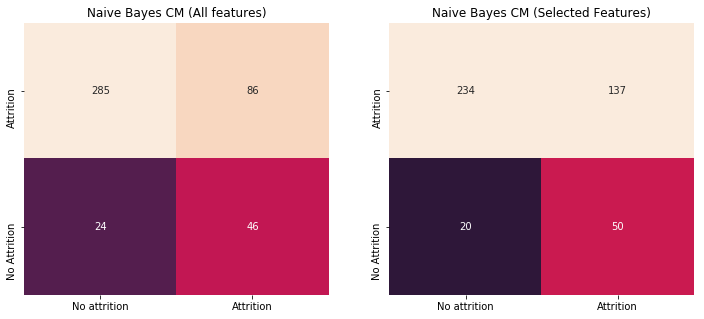

<Figure size 432x360 with 0 Axes>

In [157]:
# Build the Confusion Matrix with all features
nb_cm = confusion_matrix(attrition_test, attrition_pred_nb)

# Build the Confusion Matrix with the selected features
nb_new_cm = confusion_matrix(attrition_test_new, attrition_pred_nb_new)

# Plot all Confusion Matrix
plot_two_confusion_matrix(nb_cm, 'Naive Bayes CM (All features)', nb_new_cm, 'Naive Bayes CM (Selected Features)')

Although Naive Bayes model accuracy isn't stellar when applied to this dataset, we actually got pretty good precision accuracy on attrition when using all the features: **76%**, aligning almost perfectly with its overall accuracy of **75%**.

Running the model with only the selected features had an even better score in that regard (**83%**), but it has shown too low of an overall prediction accuracy to be a strong contender.

### Random Forest

Since we have already built and tested the random forest classifier (with both the new set of features and all of them), we can now simply jump into the grid search and test out our results. These are the hyper-parameters we will cover:
    
* n_estimators = number of trees in the forest
* max_features = max number of features considered for splitting a node
* max_depth = max number of levels in each decision tree
* min_samples_split = min number of data points placed in a node before the node is split
* min_samples_leaf = min number of data points allowed in a leaf node
* bootstrap = method for sampling data points (with or without replacement)

The following range of values were chosen:

In [158]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [30, 40, 50],
    'max_features': [6, 7, 8],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [8, 9, 10],
    'n_estimators': [200, 300, 400, 500]
}

With the grid parameters built, we can now try it out on our random forest classifier with all the features:

In [159]:
# Run grid search, print the results and get the prediction array and model
rf_grid_search_pred, rf_grid = (fit_and_pred_grid_classifier(random_forest, param_grid, features_train, 
                                                             features_test, attrition_train, attrition_test))

f1 score: 27.587713109657507%
Accuracy: 86.16780045351474%
Best parameter combination: {'bootstrap': True, 'max_depth': 30, 'max_features': 7, 'min_samples_leaf': 2, 'min_samples_split': 9, 'n_estimators': 400}


86,16% is not bad, but the F1 Score is underwhelming. Let's now try grid search with the random forest model built with a selected group of features:

In [160]:
# Run grid search, print the results and get the prediction array and model
rf_grid_search_pred_new, rf_grid_new = (fit_and_pred_grid_classifier(random_forest, param_grid, features_train_new, 
                                                                     features_test_new, attrition_train_new, attrition_test_new))

f1 score: 37.98424023994148%
Accuracy: 84.12698412698413%
Best parameter combination: {'bootstrap': True, 'max_depth': 30, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 300}


With a select group of features we obtained 84.12% accuracy, slightly worst than the previous model, but with better F1 Score. In order to better evaluate these results, let's take a look at the confusion matrix:

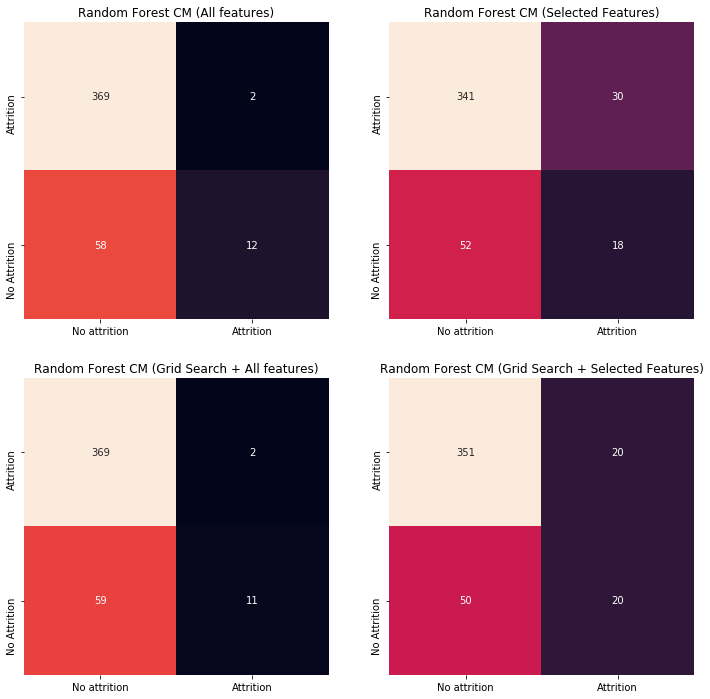

<Figure size 432x360 with 0 Axes>

In [161]:
# Build the Confusion Matrix with all features and grid search
rf_grid_cm = confusion_matrix(attrition_test, rf_grid_search_pred)

# Build the Confusion Matrix with the selected features and grid search
rf_grid_cm_new = confusion_matrix(attrition_test_new, rf_grid_search_pred_new)

# Plot the four Coufusion Matrix
plot_four_confusion_matrix(rf_cm_plot, 'Random Forest CM (All features)', 
                           rf_cm_new_plot, 'Random Forest CM (Selected Features)',
                           rf_grid_cm, 'Random Forest CM (Grid Search + All features)', 
                           rf_grid_cm_new, 'Random Forest CM (Grid Search + Selected Features)')

It's evident that the random forest model is not performing well for this problem, and in the end it's hard to choose the best one because they are all sub-par, despite having overall good accuracy. The best one is likely "Random Forest CM (Selected Features)", as even though it gets 8% of the "no attrition" predictions wrong (worst of all four), it has the best "attrition" prediction of the set.

### Custom-made ensemble

Even though a few models gave us quite good predictions (e.g. 88,88% overall accuracy with Kernel SVM by using all features, and Naive Bayes with the good attrition prediction), we could still go an extra mile and combine a few of the models implemented to make use of their strongest traits as a team. The combination of many models is called an ensemble. We'll attempt the following two combinations:
* Emsemble 1:
    1. Naive Bayes (**all features**) with 0.5 weight
    2. K-NN (**grid search** + **all features**) with 0.1 weight
    3. Random Forest (**grid search** + **all features**) with 0.3 weight
    
    
* Emsemble 2:
    1. Naive Bayes (**selected features**) with 0.5 weight
    2. K-NN (**selected features**) with 0.2 weight
    3. Random Forest (**grid search** + **selected** features) with 0.3 weight

Naive Bayes was chosen as the base classifier (highest weight) due to its high accuracy on the attrition prediction. With that, we hope to create a model that can have high overall accuracy and also be a good model for predicting attrition.

To start, we need to build our classifiers (except by Naive Bayes, since it's already built) with the optimal parameters found by grid search, as it doesn't work with models built from grid search:

In [162]:
# Ensemble 1 models
rf_ens_1 = RandomForestClassifier(max_depth = 30, max_features = 7, min_samples_leaf = 2, min_samples_split = 9, n_estimators = 400, random_state = 0)
kn_ens_1 = KNeighborsClassifier(algorithm = 'ball_tree', metric = 'minkowski', n_neighbors = 1, p = 1, weights = 'distance')

# Ensemble 2 models
rf_ens_2 = RandomForestClassifier(max_depth = 30, max_features = 7, min_samples_leaf = 1, min_samples_split = 9, n_estimators = 300, random_state = 0)
kn_ens_2 = KNeighborsClassifier(algorithm = 'brute', metric = 'minkowski', n_neighbors = 5, p = 2, weights = 'distance')

With the models built, we need to now define our own methods for building an ensemble. This is needed because the default VotingClassifier function from sklearn does not accept different feature dataframes as input, which we need since Kernel SVM and KNN use feature scaling, while naive bayes and random forest do not. The biggest issue here is that while using normalized data do not affect random forest that much, it has a very negative impact on Naive Bayes when applied.

In [163]:
# Helper method to fit multiple estimators at once
def fit_multiple_estimators(classifiers, X_list, y, sample_weights = None):
    return  [clf.fit(X, y) if sample_weights is None else clf.fit(X, y, sample_weights) for clf, X in zip([clf for _, clf in classifiers], X_list)]

# Helper method to act as an ensemble
def predict_from_multiple_estimator(estimators, X_list, weights = None):
    # Predict 'soft' voting with probabilities
    pred1 = np.asarray([clf.predict_proba(X) for clf, X in zip(estimators, X_list)])
    pred2 = np.average(pred1, axis=0, weights=weights)
    
    # Return the prediction
    return np.argmax(pred2, axis=1)

The first ensemble is built with models that use all features:

In [164]:
# Build the estimator list and the applicable feature list in correct order
classifiers = [('knn', kn_ens_1), ('rf', rf_ens_1), ('nb', naive_bayes)]
train_list = [features_train_scaled, features_train, features_train]
test_list = [features_test_scaled, features_test, features_test]

# Fit the ensemble
fitted_estimators_1 = fit_multiple_estimators(classifiers, train_list, attrition_train)

# Run a prediction for our ensemble
ensemble_1_pred = predict_from_multiple_estimator(fitted_estimators_1, test_list, weights=[1,2,5])

# Get the accuracy %
print("Accuracy with selected features: " + str(accuracy_score(attrition_test, ensemble_1_pred) * 100) + "%") 

Accuracy with selected features: 80.95238095238095%


The second ensemble is built with models that use a selected group of features:

In [165]:
# Build the estimator list and the applicable feature list in correct order
classifiers = [('knn', kn_ens_2), ('rf', rf_ens_2), ('nb', naive_bayes)]
train_list = [features_train_scaled, features_train, features_train]
test_list = [features_test_scaled, features_test, features_test]

# Fit the ensemble
fitted_estimators_2 = fit_multiple_estimators(classifiers, train_list, attrition_train)

# Run a prediction for our ensemble
ensemble_2_pred = predict_from_multiple_estimator(fitted_estimators_2, test_list, weights=[2,3,5])

# Get the accuracy %
print("Accuracy with selected features: " + str(accuracy_score(attrition_test, ensemble_2_pred) * 100) + "%") 

Accuracy with selected features: 83.6734693877551%


From a first glance, both models had an average performance, and are apparently no better than the other models we build. Let's take a look at the confusion matrix to see exactly how well it's performing:

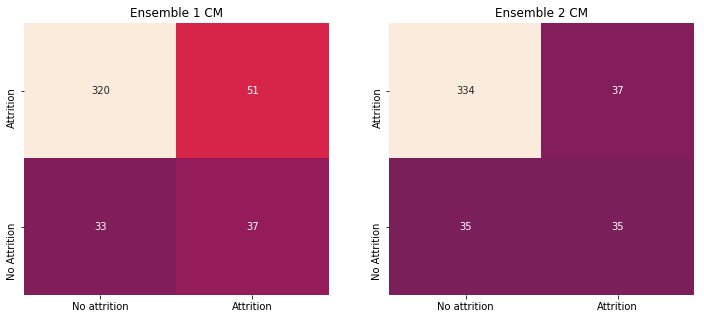

<Figure size 432x360 with 0 Axes>

In [166]:
# Build the Confusion Matrix for ensemble 1
ensemble_1_cm = confusion_matrix(attrition_test, ensemble_1_pred)

# Build the Confusion Matrix for ensemble 2
ensemble_2_cm = confusion_matrix(attrition_test_new, ensemble_2_pred)

# Plot the four Coufusion Matrix
plot_two_confusion_matrix(ensemble_1_cm, 'Ensemble 1 CM',  ensemble_2_cm, 'Ensemble 2 CM')

We ended up with two pretty similar models in the end, both showing acceptable accuracy (81% and 84% respectively) while having at least 50% attrition prediction, which is better than all models we built but Naive Bayes.

For the first ensemble I've chosen a bigger weight for Naive Bayes, which resulted in worst overall accuracy in order to score a little bit better on the attrition prediction.

# 6. Result comparison and final considerations

We've built a lot of models, some good, some bad. Out of all of them, four performed the best:
* Linear SVM with all features: **88.88%** overall accuracy, **41%** attrition accuracy
* Random Forest with selected features: **84%** overall accuracy, **28.5%** attrition accuracy
* Naive Bayes with all features: **75%** accuracy, **65.7%** attrition accuracy
* Ensemble 2, which is a combination of three models built with all features: **83.7%** accuracy, **50%** attrition accuracy

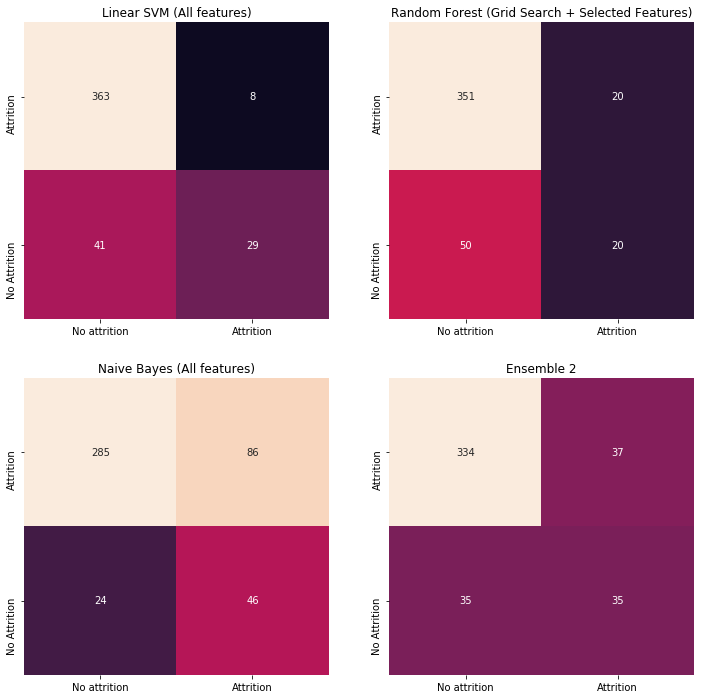

<Figure size 432x360 with 0 Axes>

In [167]:
plot_four_confusion_matrix(svc_grid_cm, 'Linear SVM (All features)', 
                           rf_grid_cm_new, 'Random Forest (Grid Search + Selected Features)',
                           nb_cm, 'Naive Bayes (All features)', 
                           ensemble_2_cm, 'Ensemble 2')

---

To help answer the question of "what causes attrition at the workplace?", we need to re-visit the relative importance we got from Random Forest and contextualize it to the results we obtained:

With all features:

* Overtime
* Marital status
* Working with sales or research
* Management positions.

With selected group of features:

* Years at company
* Years with same manager
* Years since last promotion
* Gender

This hypothesis can be validated through a set of plots:

[Text(0.5, 1.0, 'Overtime against against Attrition')]

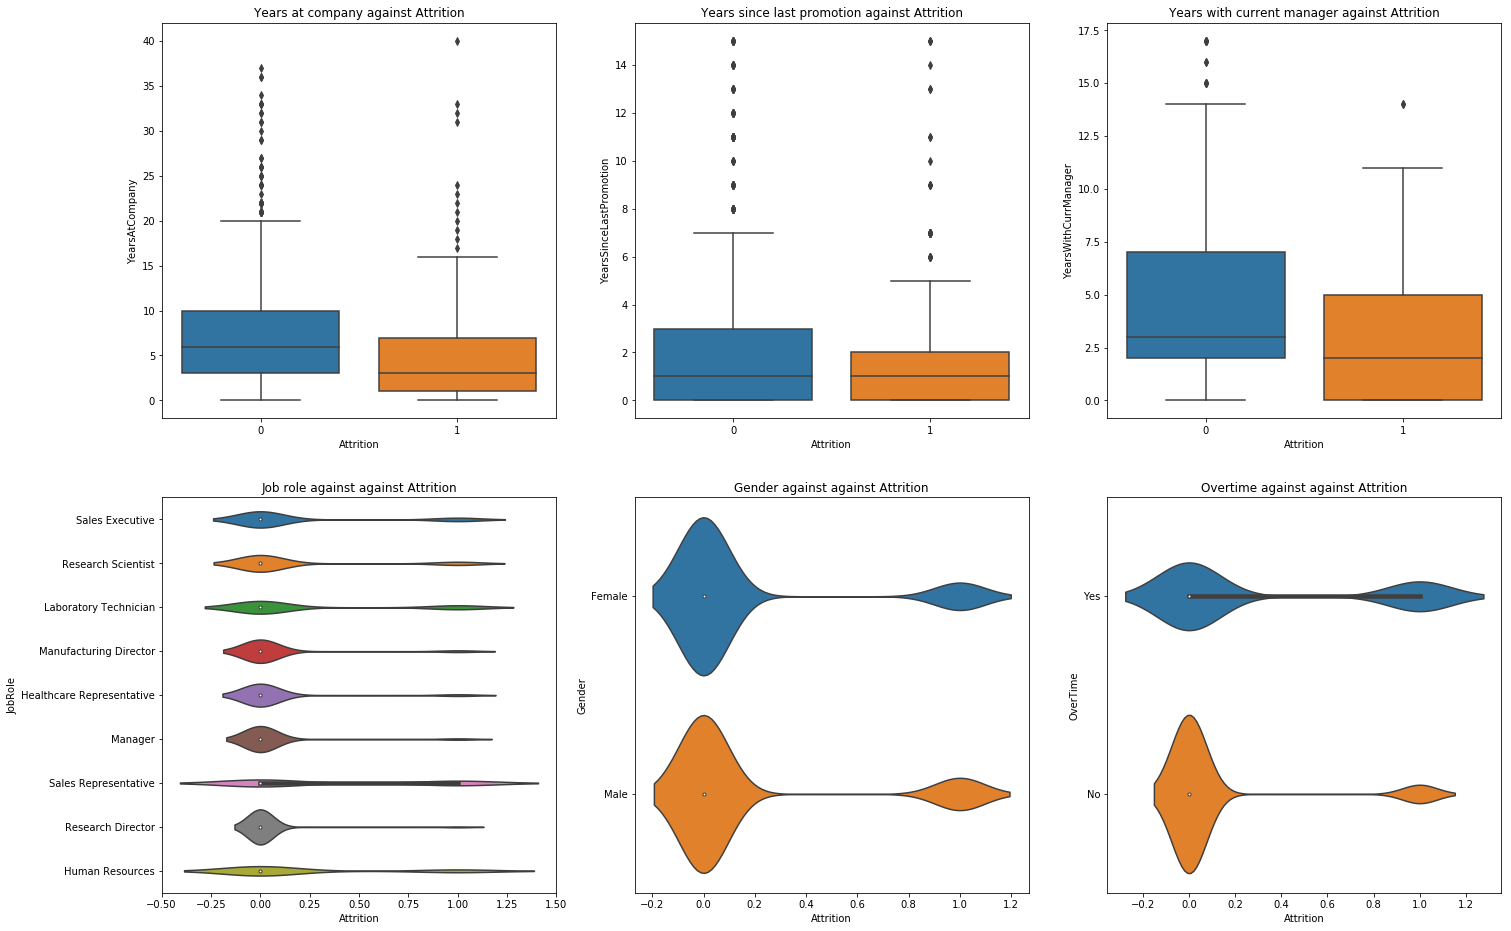

In [168]:
# Add the encoded attrition to the original dataset, to allow it being combined plotted with categorical features
encoded_dataset = dataset
encoded_dataset['Attrition'] = output

# Define a set of graphs, 2 by 3, usin the matplotlib library
f, axes = plt.subplots(2, 3, figsize=(24, 16), sharex=False, sharey=False)

sns.boxplot(x="Attrition", y="YearsAtCompany", data=encoded_dataset, ax=axes[0,0])
axes[0,0].set( title = 'Years at company against Attrition')

sns.boxplot(x="Attrition", y="YearsSinceLastPromotion", data=encoded_dataset, ax=axes[0,1])
axes[0,1].set( title = 'Years since last promotion against Attrition')

sns.boxplot(x="Attrition", y="YearsWithCurrManager", data=encoded_dataset, ax=axes[0,2])
axes[0,2].set( title = 'Years with current manager against Attrition')

sns.violinplot(x="Attrition", y="JobRole", data=encoded_dataset, ax=axes[1,0])
axes[1,0].set( title = 'Job role against against Attrition')

sns.violinplot(x="Attrition", y="Gender", data=encoded_dataset, ax=axes[1,1])
axes[1,1].set( title = 'Gender against against Attrition')

sns.violinplot(x="Attrition", y="OverTime", data=encoded_dataset, ax=axes[1,2])
axes[1,2].set( title = 'Overtime against against Attrition')

The plot above shows that there's a strong relation between attrition and years with same manager, years since last promotion and years at the same company and doing overtime, but gender seems to have no real effect on it. Additionally, sales representative are also more prone to have work attrition.

We got mixed results with our models, but for the most cases those that were built with all features had better overall prediction accuracy, while having worst attrition accuracy. This mean we can trust that the features we selected are very good indicators of attrition, and one should keep an eye on employees who are stuck in the same situation for long periods of time, specially those that do overtime and/or work with sales. In short, variety is the spice of life, and dealing with people to meet a quota is stressful.

We're at the end of our journey. Several techniques were evaluated on this study, and there are a few conclusions that can be drawn from this analysis:

There's either a limit of how well attrition can be predicted with the known features, or feature selection can be improved in order to achieve better results. A future study could be done to focus on feature selection alone, re-running the algorithms built here.
The simplest model (Naive Bayes) is probably the most useful one.
So, what model to use? I would personally go with Naive Bayes (with all features): even though the overall accuracy is a bit underwhelming (75%), the attrition prediction is too valuable to pass. It's better raise false alarms (depending on how that is conducted) than to miss the change to identify attrition before it occurs.